In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'bloodmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64)
val_dataset = DataClass(split='val', transform=data_transform, download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 156251765/156251765 [00:08<00:00, 18050506.28it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

Dataset BloodMNIST of size 64 (bloodmnist_64)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: C

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


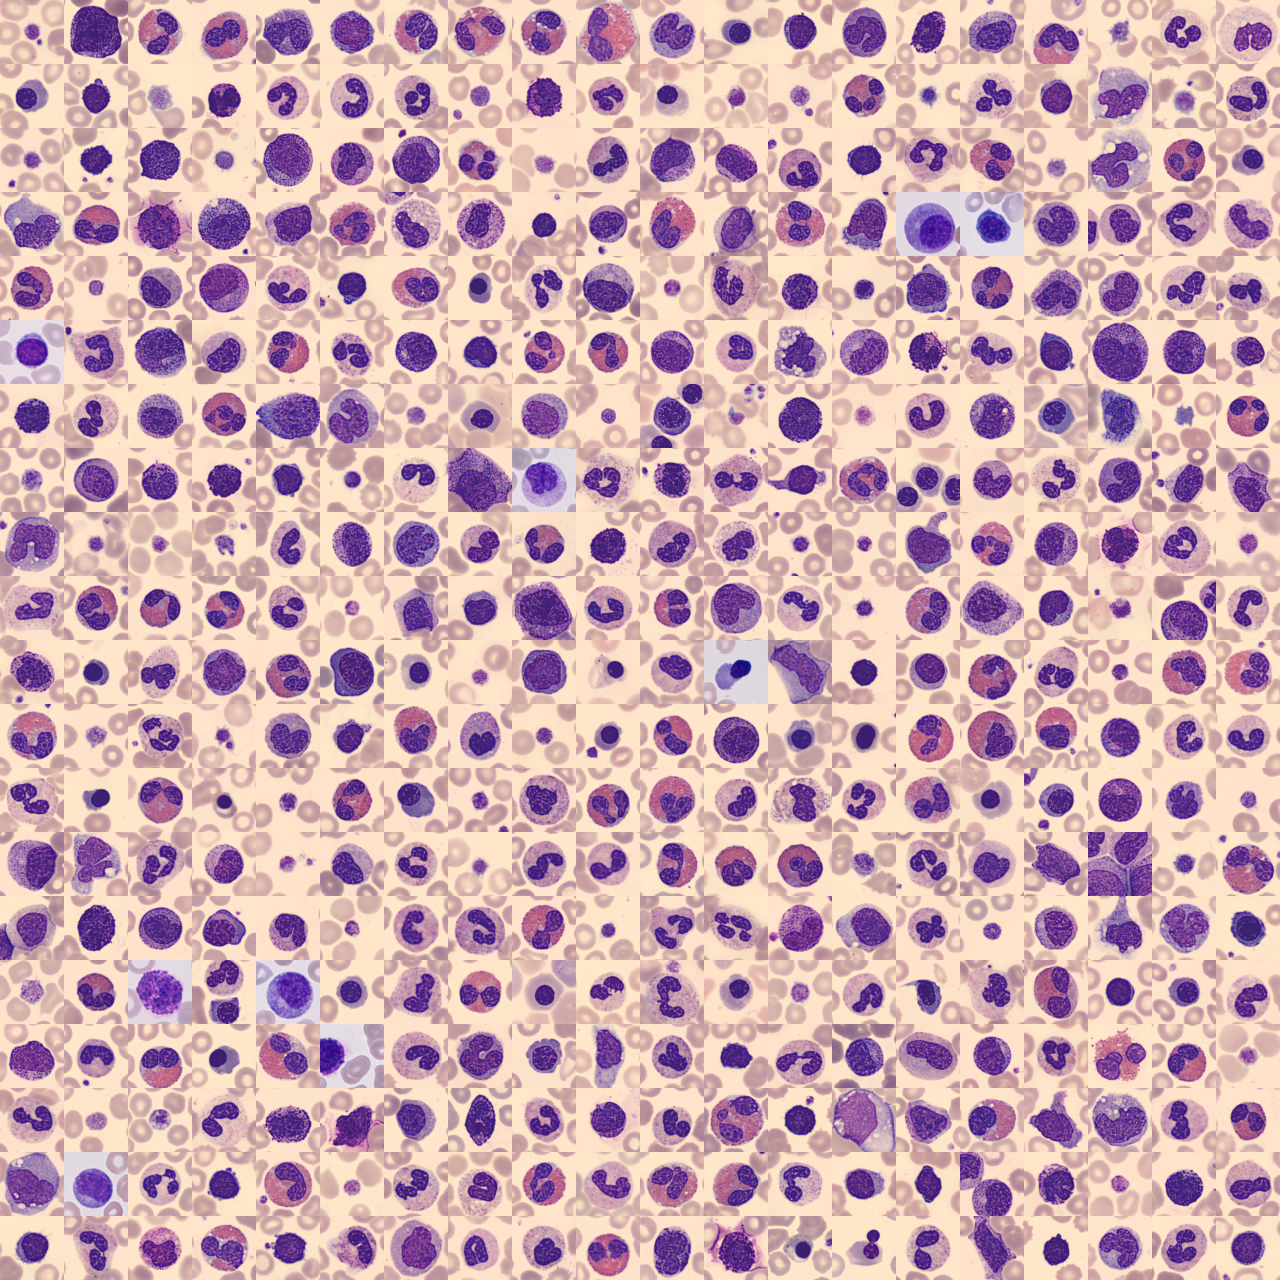

In [ ]:
train_dataset.montage(length=20)

In [ ]:
images, _ = next(iter(train_loader))  # Pegando o primeiro lote de imagens

# Visualizando a dimensão da primeira imagem no lote
print("Dimensão da primeira imagem:", images[0].size())

Dimensão da primeira imagem: torch.Size([3, 64, 64])


# **MLP**

Evaluating model with hidden size: 64
Test Accuracy: 0.8626132709733996
Evaluating model with hidden size: 128
Test Accuracy: 0.8629055831628178
Evaluating model with hidden size: 256
Test Accuracy: 0.8547208418591056
Evaluating model with hidden size: 512
Test Accuracy: 0.884536685179772
Evaluating model with hidden size: 1024
Test Accuracy: 0.866997953814674
Best Model:
Hidden Size: 512
Test Accuracy: 0.884536685179772


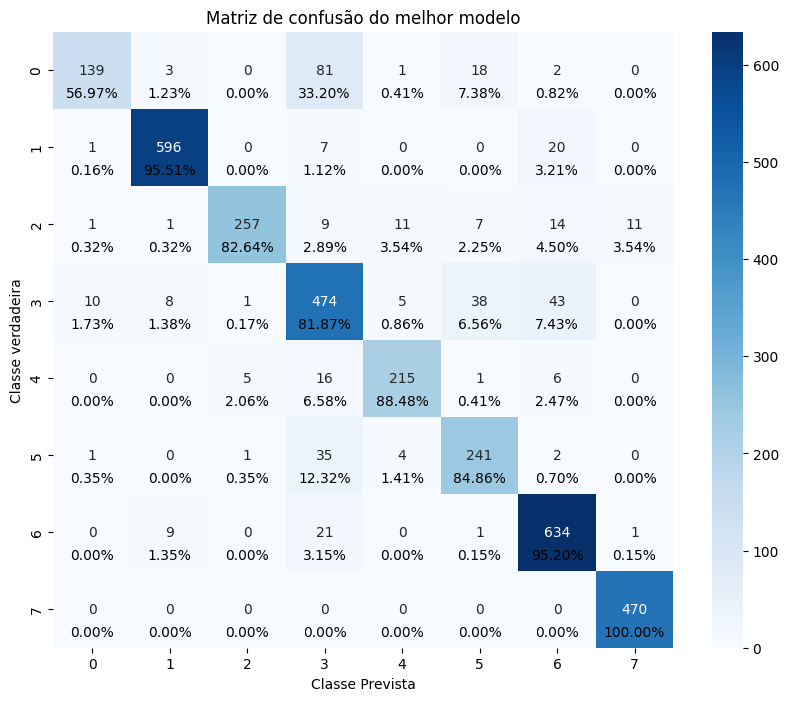

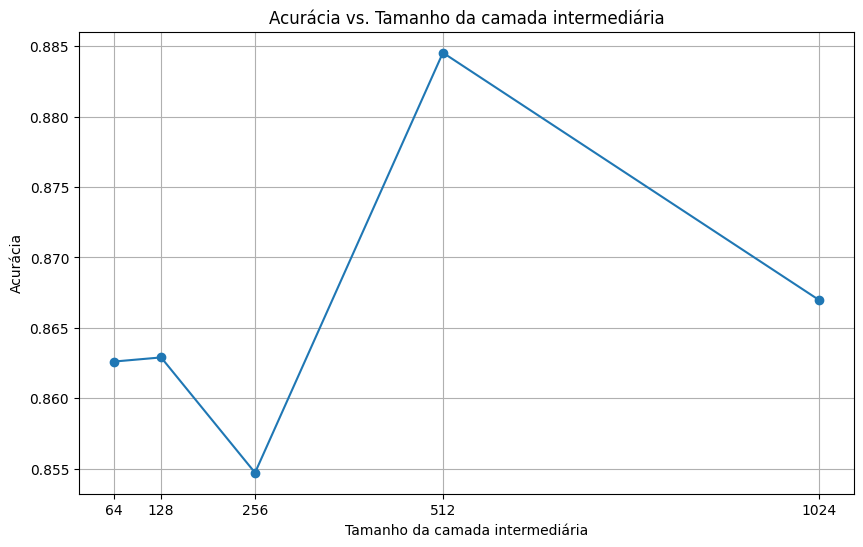

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, hidden_size), # Camada de entrada
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.main(x)
        return x

def calculate_accuracy(model, dataloader):
    model.eval()
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    return accuracy_score(all_labels, all_predicted)

def calculate_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    return confusion_matrix(all_labels, all_predicted)

input_size = 64 * 64 * 3  # Tamanho da entrada (28x28x3)
output_size = 8          # Número de classes
hidden_sizes = [64, 128, 256, 512, 1024]
best_accuracy = 0
best_conf_matrix = None
best_hidden_size = None
accuracies = []

for hidden_size in hidden_sizes:
    print(f"Evaluating model with hidden size: {hidden_size}")

    # Instancia o modelo
    model = MLP(input_size, hidden_size, output_size).to(device)

    # Define a função de perda e o otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Treinamento do modelo
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        #print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss}")

    # Avaliação do modelo nos dados de teste
    test_accuracy = calculate_accuracy(model, test_loader)
    accuracies.append(test_accuracy)
    print("Test Accuracy:", test_accuracy)

    # Atualiza o melhor modelo se necessário
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_hidden_size = hidden_size
        best_conf_matrix = calculate_confusion_matrix(model, test_loader)

# Imprime a acurácia do melhor modelo
print("Best Model:")
print("Hidden Size:", best_hidden_size)
print("Test Accuracy:", best_accuracy)

# Plota a matriz de confusão do melhor modelo
conf_matrix_percent = best_conf_matrix / best_conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8),facecolor='white')
plt.tight_layout()
sns.heatmap(best_conf_matrix, annot=True, fmt="d", cmap="Blues")
for i in range(best_conf_matrix.shape[0]):
    for j in range(best_conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.8, "{:.2%}".format(conf_matrix_percent[i, j]),
                 ha='center', va='center', color='black')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe verdadeira')
plt.title('Matriz de confusão do melhor modelo')
plt.savefig('cm_mlp.png', bbox_inches='tight')

# Plota o gráfico de acurácia vs. tamanhos ocultos
plt.figure(figsize=(10, 6),facecolor='white')
plt.tight_layout()
plt.plot(hidden_sizes, accuracies, marker='o', linestyle='-')
plt.title('Acurácia vs. Tamanho da camada intermediária')
plt.xlabel('Tamanho da camada intermediária')
plt.ylabel('Acurácia')
plt.grid(True)
plt.xticks(hidden_sizes)
plt.savefig('ah_mlp.png', bbox_inches='tight')

# **CNN simples**

Training with 64 kernels and kernel size 2x2:
0.9415887850467289

Training with 64 kernels and kernel size 3x3:
0.9462616822429907

Training with 64 kernels and kernel size 4x4:
0.9439252336448598

Training with 128 kernels and kernel size 2x2:
0.9427570093457944

Training with 128 kernels and kernel size 3x3:
0.9445093457943925

Training with 128 kernels and kernel size 4x4:
0.9485981308411215

Training with 256 kernels and kernel size 2x2:
0.9485981308411215

Training with 256 kernels and kernel size 3x3:
0.9468457943925234

Training with 256 kernels and kernel size 4x4:
0.9450934579439252

Training with 512 kernels and kernel size 2x2:
0.9503504672897196

Training with 512 kernels and kernel size 3x3:
0.9480140186915887

Training with 512 kernels and kernel size 4x4:
0.9497663551401869



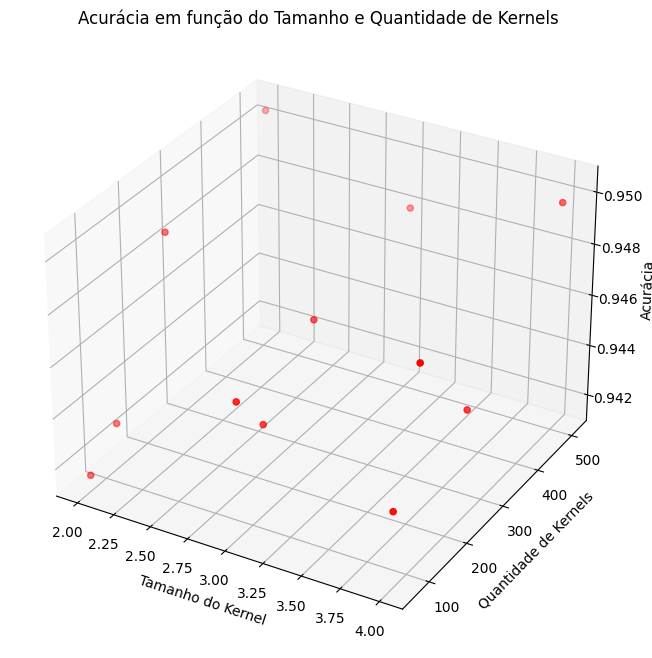

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, input_size, output_size, num_kernels, kernel_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=num_kernels, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Adicionando um nn.Flatten() aqui não precisa do conv_out_size e x.view(x.size(0), -1)
        )
        # Calculate the output size after convolution and pooling
        conv_out_size = (((input_size - kernel_size + 1) - 2) // 2 + 1) ** 2

        # Define the fully connected layer
        self.fc = nn.Linear(conv_out_size * num_kernels, output_size)

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Parâmetros
num_epochs = 20
lr = 0.001
input_size = 64
output_size = 8

from mpl_toolkits.mplot3d import Axes3D

# Listas para armazenar os resultados
kernel_sizes = []
num_kernels_values = []
accuracies = []

def train_and_validate(num_kernels, kernel_size):
    # Definindo a CNN
    model = SimpleCNN(input_size=input_size, output_size=output_size, num_kernels=num_kernels, kernel_size=kernel_size)

    # Movendo o modelo para o dispositivo de hardware disponível
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Definindo a função de perda e o otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Treinamento da CNN
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

    model.eval()
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_predicted)
    print(accuracy)

    # Armazenar os resultados
    kernel_sizes.append(kernel_size)
    num_kernels_values.append(num_kernels)
    accuracies.append(accuracy)

# Testando diferentes configurações de kernels e tamanhos de kernel
num_kernels_list = [64, 128, 256, 512]  # Quantidade de kernels
kernel_size_list = [2, 3, 4]       # Tamanho do kernel

for num_kernels in num_kernels_list:
    for kernel_size in kernel_size_list:
        print(f"Training with {num_kernels} kernels and kernel size {kernel_size}x{kernel_size}:")
        train_and_validate(num_kernels, kernel_size)
        print()

# Plotar o gráfico 3D
fig = plt.figure(figsize=(10, 8),facecolor='white')
fig.tight_layout()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kernel_sizes, num_kernels_values, accuracies, c='r', marker='o')
ax.set_xlabel('Tamanho do Kernel')
ax.set_ylabel('Quantidade de Kernels')
ax.set_zlabel('Acurácia')
plt.title('Acurácia em função do Tamanho e Quantidade de Kernels')
fig.savefig('cnn3d.png', bbox_inches='tight')

Epoch 1/20, Loss: 9.20996992448543
Epoch 2/20, Loss: 0.42805930552013377
Epoch 3/20, Loss: 0.21610332327954312
Epoch 4/20, Loss: 0.11685486775922015
Epoch 5/20, Loss: 0.07077853421264506
Epoch 6/20, Loss: 0.06268480411195691
Epoch 7/20, Loss: 0.028203848704814592
Epoch 8/20, Loss: 0.09527314416172498
Epoch 9/20, Loss: 0.025391426432798517
Epoch 10/20, Loss: 0.013562495260439972
Epoch 11/20, Loss: 0.018559922008438312
Epoch 12/20, Loss: 0.005871812393145754
Epoch 13/20, Loss: 0.0028499589200091965
Epoch 14/20, Loss: 0.0021540939862384123
Epoch 15/20, Loss: 0.001756483457358356
Epoch 16/20, Loss: 0.0015629576791593052
Epoch 17/20, Loss: 0.0014993898933406602
Epoch 18/20, Loss: 0.0012624799434908052
Epoch 19/20, Loss: 0.0011571580426460331
Epoch 20/20, Loss: 0.001060581448403722
Test Accuracy: 0.9415375621163402


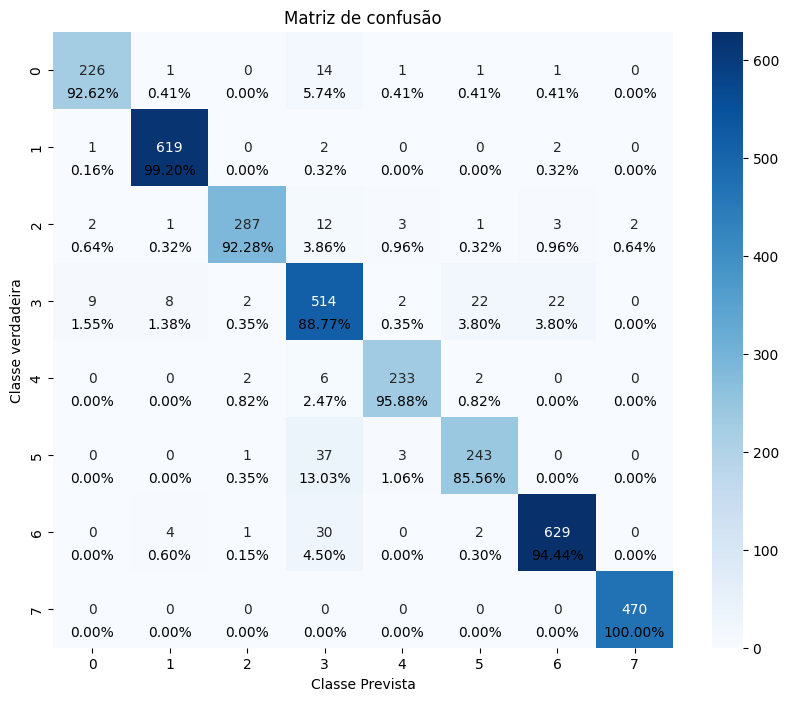

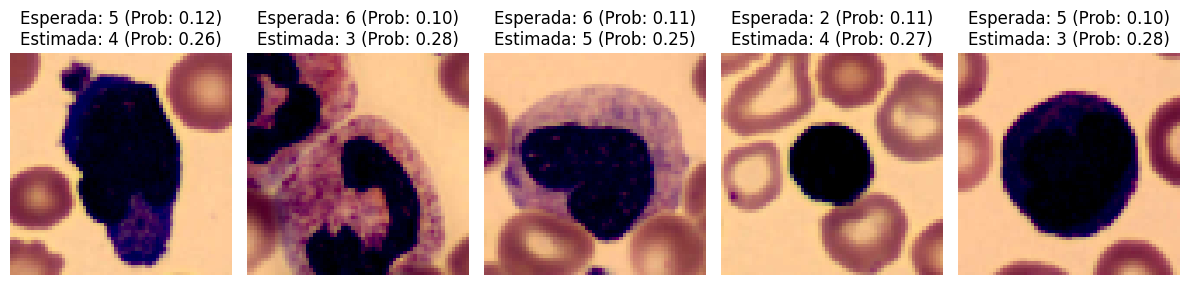

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class SimpleCNN(nn.Module):
    def __init__(self, input_size, output_size, num_kernels, kernel_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=num_kernels, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Adicionando um nn.Flatten() aqui não precisa do conv_out_size e x.view(x.size(0), -1)
        )
        # Calculate the output size after convolution and pooling
        conv_out_size = (((input_size - kernel_size + 1) - 2) // 2 + 1) ** 2

        # Define the fully connected layer
        self.fc = nn.Linear(conv_out_size * num_kernels, output_size)

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Parâmetros
num_epochs = 20
lr = 0.001
input_size = 64
output_size = 8

model = SimpleCNN(input_size=64, output_size=8, num_kernels=512, kernel_size=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Defina a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    running_loss = 0.0
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

def calculate_accuracy(model, dataloader):
    model.eval()
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    return accuracy_score(all_labels, all_predicted)

# 5. Função para calcular a matriz de confusão
def calculate_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    return confusion_matrix(all_labels, all_predicted)

# 6. Avalie o modelo nos dados de teste
test_accuracy = calculate_accuracy(model, test_loader)
conf_matrix = calculate_confusion_matrix(model, test_loader)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
print("Test Accuracy:", test_accuracy)


# Cria a visualização usando seaborn
plt.figure(figsize=(10, 8),facecolor='white')
plt.tight_layout()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.8, "{:.2%}".format(conf_matrix_percent[i, j]),
                 ha='center', va='center', color='black')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe verdadeira')
plt.title('Matriz de confusão')
plt.savefig('cm_cnn.png', bbox_inches='tight')

# Identifique cinco exemplos de predições incorretas
def get_incorrect_predictions(model, test_loader, device):
    incorrect_samples = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    image = data[i]  # Obtenha a imagem
                    true_label = labels[i].item()  # Obtenha a classe esperada
                    predicted_label = predicted[i].item()  # Obtenha a classe predita
                    probabilities = nn.functional.softmax(outputs[i], dim=0).cpu().numpy()  # Obtenha as probabilidades estimadas
                    incorrect_samples.append((image, true_label, predicted_label, probabilities))
                    if len(incorrect_samples) == 5:
                        return incorrect_samples
    return incorrect_samples

# Obtenha cinco exemplos de predições incorretas
incorrect_samples = get_incorrect_predictions(model, test_loader, device)

# Plotar as cinco imagens incorretamente classificadas
fig, axes = plt.subplots(1, 5, figsize=(12, 3), facecolor='white')
for i, (image, true_label, predicted_label, probabilities) in enumerate(incorrect_samples):
    image = image.permute(1, 2, 0).cpu()  # Alterar a ordem das dimensões para imagem e transferir para a memória do host
    prob_estimada = nn.functional.softmax(torch.tensor(probabilities), dim=0)  # Converter o array NumPy de probabilidades para tensor do PyTorch e aplicar softmax
    prob_esperada = prob_estimada[true_label]
    axes[i].imshow(image)
    axes[i].set_title(f'Esperada: {true_label} (Prob: {prob_esperada:.2f})\nEstimada: {predicted_label} (Prob: {prob_estimada.max().item():.2f})')
    axes[i].axis('off')
plt.tight_layout()
plt.savefig('5padroes_cnn.png', bbox_inches='tight')

# **DeepCNN**

In [ ]:
# Função para os blocos convolucionais
def conv_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, 1, 1),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(),
      nn.Conv2d(out_channels, out_channels, 3, 1, 1),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, 2)
  )


class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Sequential(
            nn.Linear(2*2*1024, 1024),
            nn.LeakyReLU()
        )
        self.linear2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU()
        )
        self.linear3 = nn.Linear(1024, 8)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Epoch 1/20, Loss: 1.3395024886790743
Epoch 2/20, Loss: 0.8126667325801038
Epoch 3/20, Loss: 0.5557491256201521
Epoch 4/20, Loss: 0.4197892281920352
Epoch 5/20, Loss: 0.3556842677136685
Epoch 6/20, Loss: 0.267309613446606
Epoch 7/20, Loss: 0.23276416529366312
Epoch 8/20, Loss: 0.2080631338535471
Epoch 9/20, Loss: 0.17643865962770391
Epoch 10/20, Loss: 0.1476865947008767
Epoch 11/20, Loss: 0.15959029426758595
Epoch 12/20, Loss: 0.12028254392219985
Epoch 13/20, Loss: 0.10862154250053015
Epoch 14/20, Loss: 0.09953479607530097
Epoch 15/20, Loss: 0.09528960066629534
Epoch 16/20, Loss: 0.08439834755746291
Epoch 17/20, Loss: 0.08913133043716563
Epoch 18/20, Loss: 0.08556720280544237
Epoch 19/20, Loss: 0.07057653840116047
Epoch 20/20, Loss: 0.06895010280323789
Test Accuracy: 0.9725226541946799


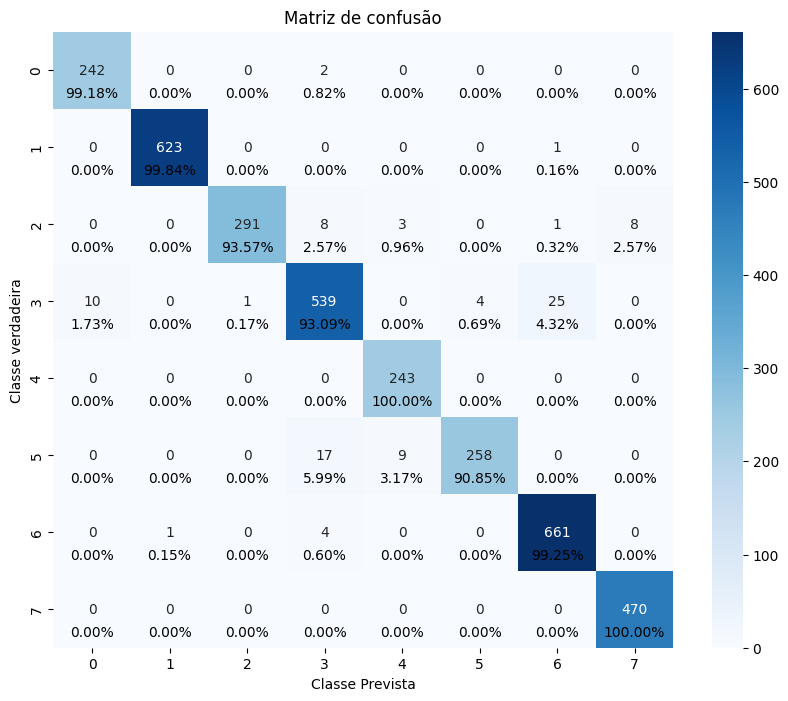

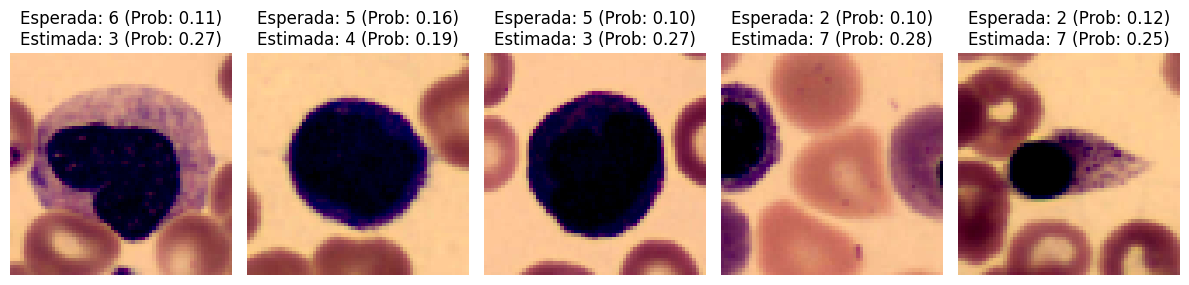

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

model = DeepCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Defina a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

def calculate_accuracy(model, dataloader):
    model.eval()
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    return accuracy_score(all_labels, all_predicted)

# 5. Função para calcular a matriz de confusão
def calculate_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    return confusion_matrix(all_labels, all_predicted)

# 6. Avalie o modelo nos dados de teste
test_accuracy = calculate_accuracy(model, test_loader)
conf_matrix = calculate_confusion_matrix(model, test_loader)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
print("Test Accuracy:", test_accuracy)


# Cria a visualização usando seaborn
plt.figure(figsize=(10, 8),facecolor='white')
plt.tight_layout()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.8, "{:.2%}".format(conf_matrix_percent[i, j]),
                 ha='center', va='center', color='black')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe verdadeira')
plt.title('Matriz de confusão')
plt.savefig('cm_deepcnn2.png', bbox_inches='tight')

def get_incorrect_predictions(model, test_loader, device):
    incorrect_samples = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    image = data[i]  # Obtenha a imagem
                    true_label = labels[i].item()  # Obtenha a classe esperada
                    predicted_label = predicted[i].item()  # Obtenha a classe predita
                    probabilities = nn.functional.softmax(outputs[i], dim=0).cpu().numpy()  # Obtenha as probabilidades estimadas
                    incorrect_samples.append((image, true_label, predicted_label, probabilities))
                    if len(incorrect_samples) == 5:
                        return incorrect_samples
    return incorrect_samples

# Obtenha cinco exemplos de predições incorretas
incorrect_samples = get_incorrect_predictions(model, test_loader, device)

# Plotar as cinco imagens incorretamente classificadas
fig, axes = plt.subplots(1, 5, figsize=(12, 3), facecolor='white')
for i, (image, true_label, predicted_label, probabilities) in enumerate(incorrect_samples):
    image = image.permute(1, 2, 0).cpu()  # Alterar a ordem das dimensões para imagem e transferir para a memória do host
    prob_estimada = nn.functional.softmax(torch.tensor(probabilities), dim=0)  # Converter o array NumPy de probabilidades para tensor do PyTorch e aplicar softmax
    prob_esperada = prob_estimada[true_label]
    axes[i].imshow(image)
    axes[i].set_title(f'Esperada: {true_label} (Prob: {prob_esperada:.2f})\nEstimada: {predicted_label} (Prob: {prob_estimada.max().item():.2f})')
    axes[i].axis('off')
plt.tight_layout()
plt.savefig('5padroes_deepcnn.png', bbox_inches='tight')